In [ ]:
!pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 39.1 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.20.3
    Uninstalling huggingface-hub-0.20.3:
      Successfully uninstalled huggingface-hub-0.20.3


In [ ]:
#Import required libraries
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchtext
from torchtext.data import get_tokenizer
from torchtext.vocab import GloVe
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import torch
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
from datasets import load_dataset

# Load IMDB data
df = load_dataset("stanfordnlp/imdb")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
train_data = df["train"]
test_data = df["test"]

In [ ]:
train_df = pd.DataFrame(df["train"])
test_df = pd.DataFrame(df["test"])

In [ ]:
def preprocess(text):
    text = text.lower() #lowercase the rext
    text = re.sub('<br />', '', text) #remove hyperlink
    text = re.sub(r'http\S+', '', text) #remove webaddress
    text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text)

    return text

In [ ]:
train_df['cleaned_text'] = [preprocess(text) for text in train_df['text']]

In [ ]:

test_df['cleaned_text'] = [preprocess(text) for text in test_df['text']]

In [ ]:
train_df.head()

,text,label,cleaned_text
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,i rented i am curious-yellow from my video sto...
1,"""I Am Curious: Yellow"" is a risible and preten...",0,"""i am curious: yellow"" is a risible and preten..."
2,If only to avoid making this type of film in t...,0,if only to avoid making this type of film in t...
3,This film was probably inspired by Godard's Ma...,0,this film was probably inspired by godard's ma...
4,"Oh, brother...after hearing about this ridicul...",0,"oh, brother...after hearing about this ridicul..."


In [ ]:
# Define the IMDB dataset
class IMDb_Dataset(Dataset):
    def __init__(self, reviews, labels, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = get_tokenizer('basic_english')
        self.vocab = GloVe(name='6B', dim=300)
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review = self.reviews.iloc[idx]
        label = self.labels.iloc[idx]
        tokens = self.tokenizer(review)
        vectors = self.vocab.get_vecs_by_tokens(tokens)
        padded_vectors = torch.zeros(self.max_length, vectors.shape[1])
        padded_vectors[:len(vectors)] = vectors[:self.max_length]
        return padded_vectors, label

In [ ]:
# Define the model architecture
class Imdb_SentimentModel(nn.Module):
    def __init__(self, input_layer, hidden_layer, output_layer):
        super().__init__()
        self.lstm = nn.LSTM(input_layer, hidden_layer, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_layer*2, output_layer)

    def forward(self, text):
        _, (x, _) = self.lstm(text)
        x = torch.cat((x[-2, :, :], x[-1, :, :]), dim=1)
        output = self.fc(x)
        return output

# Set up the model, loss function, and optimizer
input_layer = 300  # 300 vector word embeddings for words in corpus
hidden_layer = 128  # nuber of neuron in hidden layer
output_layer= 2 # two nuerons in output layer(as we have two classes 0 and 1)
learning_rate = 0.0003
batch_size = 32
# num_epochs = 2
max_length = 500 #maximum length for the padded vectors


In [ ]:
import torch
device = torch.device('cuda')

In [ ]:
model = Imdb_SentimentModel(input_layer, hidden_layer, output_layer) # imdb model instance
model = model.to(device) # to run on GPU
criterion = nn.CrossEntropyLoss() # loss function
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01) # using ADAM optimizer

In [ ]:
#split data into train and validation 20% for test and 80% for training
x_train, x_val, y_train, y_val = train_test_split(train_df['cleaned_text'], train_df['label'], test_size=0.2, random_state=42)


In [ ]:
#split the data and use 20% data for testing
x_test, rest_x, y_test, rest_y = train_test_split(test_df['cleaned_text'], test_df['label'], train_size=0.2, random_state=42)

In [ ]:
train_dataset = IMDb_Dataset(x_train, y_train, max_length=800) # create dataset to use in dataloader
test_dataset = IMDb_Dataset(x_test, y_test, max_length=800)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # create dataloader in batch size or 32
test_loader = DataLoader(test_dataset, batch_size=32,shuffle=False )

In [ ]:
test_dataset.reviews # display reviews in dataset created

23703    ý thýnk uzak ýs the one of the best films of a...
1717     this movie started out as a quite decent-looki...
2696     as was mentioned before in other comments, the...
1848     ghoulies iv starts in a museum storage facilit...
10623    i watched this as part of a vampire movie mara...
                               ...                        
21575    it's possible to have a good time with this fi...
5390     'illuminata' has expanded the limits of john t...
860      without being really the worst science fiction...
15795    a film is beyond all expectations, an excellen...
23654    the show itself basically reflects the typical...
Name: cleaned_text, Length: 5000, dtype: object

In [ ]:
#to verify feature vector obtained from Glove
for x, y in test_dataset:
  print(x)
  break

tensor([[ 0.3552, -0.4331,  0.0926,  ..., -0.0437,  0.0082, -0.0103],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.5656, -0.4291,  0.5192,  ...,  0.2070,  0.2247,  0.2425],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])


In [ ]:
val_dataset = IMDb_Dataset(x_val, y_val, max_length=800)
val_dataloader = DataLoader(dataset=val_dataset,batch_size=32, shuffle=True)

In [ ]:
device = torch.device('cuda')

In [ ]:
# partially adapted from the Lab
best_val_loss = 100  # highest can be 100% so using 100 to compare
state_dict_best_model = None
loss_train = []
loss_val = []
acc_train = []
acc_val = []
patience = 5  # num epochs to wait for improvement
counter_earlyStop = 0
epochs = 15

for epoch in range(epochs):
    model.train()
    total_batch_loss = 0.0
    total_correct = 0
    total_samples = 0

    for text, labels in train_loader:

        text = text.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(text)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_batch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    # Average training loss and accuracy for the epoch
    epoch_loss_train = total_batch_loss / len(train_loader)
    epoch_acc_train = total_correct / total_samples
    loss_train.append(epoch_loss_train)
    acc_train.append(epoch_acc_train)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss_train:.4f}, Training Accuracy: {epoch_acc_train:.4f}")

    # Perform validation
    model.eval()
    total_batch_loss_val = 0.0
    total_correct_val = 0
    total_samples_val = 0

    with torch.no_grad():
        for text, labels in val_dataloader:
            text = text.to(device)
            labels = labels.to(device)

            # Feed forward
            outputs = model(text)
            loss = criterion(outputs, labels)

            total_batch_loss_val += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_correct_val += (predicted == labels).sum().item()
            total_samples_val += labels.size(0)

    # Average validation loss and accuracy for the epoch
    epoch_loss_val = total_batch_loss_val / len(val_dataloader)
    epoch_acc_val = total_correct_val / total_samples_val
    loss_val.append(epoch_loss_val)
    acc_val.append(epoch_acc_val)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {epoch_loss_val:.4f}, Validation Accuracy: {epoch_acc_val:.4f}")

Epoch [1/15], Training Loss: 0.6704, Training Accuracy: 0.5796
Epoch [1/15], Validation Loss: 0.5702, Validation Accuracy: 0.7224
Epoch [2/15], Training Loss: 0.6129, Training Accuracy: 0.6830
Epoch [2/15], Validation Loss: 0.5712, Validation Accuracy: 0.7198
Epoch [3/15], Training Loss: 0.6320, Training Accuracy: 0.6455
Epoch [3/15], Validation Loss: 0.6643, Validation Accuracy: 0.6146
Epoch [4/15], Training Loss: 0.6494, Training Accuracy: 0.6299
Epoch [4/15], Validation Loss: 0.6778, Validation Accuracy: 0.5540
Epoch [5/15], Training Loss: 0.6444, Training Accuracy: 0.6412
Epoch [5/15], Validation Loss: 0.6154, Validation Accuracy: 0.6814
Epoch [6/15], Training Loss: 0.6650, Training Accuracy: 0.6122
Epoch [6/15], Validation Loss: 0.6606, Validation Accuracy: 0.6136
Epoch [7/15], Training Loss: 0.6488, Training Accuracy: 0.6438
Epoch [7/15], Validation Loss: 0.6399, Validation Accuracy: 0.6770
Epoch [8/15], Training Loss: 0.6483, Training Accuracy: 0.6361
Epoch [8/15], Validation Lo

In [ ]:
# evalute results on test data
model.eval()
with torch.no_grad():
        y_predict = []
        y = []
        for text, labels in test_loader:
          text = text.to(device)
          labels = labels.to(device)
          outputs = model(text)
          _, predicted = torch.max(outputs.data, 1)
          y_predict.extend(predicted.cpu().numpy())
          y.extend(labels.cpu().numpy())


In [ ]:
print('Glove Word Embedding Bi-directional LSTM Model Performance:')
print('Accuracy: ', accuracy_score(y, y_predict))
print('Precision: ', precision_score(y, y_predict))
print('F1_score: ', f1_score(y, y_predict))

Glove Word Embedding Bi-directional LSTM Model Performance:
Accuracy:  0.8532
Precision:  0.8304029304029305
F1_score:  0.860668185269552


<Axes: >

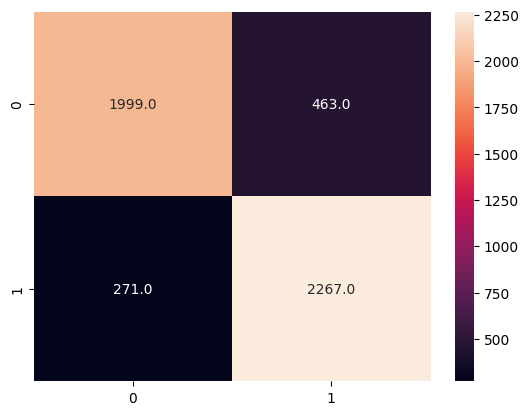

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
sns.heatmap(confusion_matrix(y,y_predict), annot=True, fmt= '.1f')

In [ ]:
error_analysis = pd.DataFrame(x_test)

In [ ]:
error_analysis['label'] = y_test
error_analysis['pred_label'] = y_predict


In [ ]:
error_analysis_df= error_analysis[error_analysis['label']!=error_analysis['pred_label']]

In [ ]:
# error_analysis_df.to_csv('Glove_bidirectional_LSTM.csv')